In [1]:
class Utils:
    @staticmethod
    def displaySideBySide(left_img, left_title, right_img, right_title, figsize=(20,10) , left_cmap=None, right_cmap=None):
        fig, axes = plt.subplots(ncols=2, figsize=figsize)
        if left_cmap == None:
            axes[0].imshow(left_img)
        else:
            axes[0].imshow(left_img, cmap=left_cmap)
        axes[0].set_title(left_title)

        if right_cmap == None:
            axes[1].imshow(right_img)
        else:
            axes[1].imshow(right_img, cmap=right_cmap)
        axes[1].set_title(right_title)
        
    @staticmethod
    def calculateCurvature(yRange, left_fit_cr):
            return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    
    @staticmethod
    def readInRGB(img_name):
        return cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)        

In [2]:
import cv2
import glob
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

class DistortionCorrector:

    def __init__(self):
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
        self.dist = None
        self.mtx = None

    def train(self, file_names="", nx=8, ny=6):
        objp = np.zeros((ny*nx,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
        images = glob.glob(file_names)
        for idx, fname in enumerate(images):
            img = Utils.readInRGB(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

    def cal_undistort(self, img, color_schema=cv2.COLOR_RGB2GRAY, verbose=0):
        gray_img = cv2.cvtColor(img, color_schema)
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, gray_img.shape[::], None, None)
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        if verbose != 0:
            Utils.displaySideBySide(
                original, 'Original',
                undist, 'Undistorted')
        return undist

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

    
distortion_corrector = DistortionCorrector()
distortion_corrector.train(file_names="./camera_cal/cali*", nx=9, ny=6)


In [3]:
# Define a class to receive the characteristics of each line detection
# TODO(fatih) Revisit this one
class Line:
    def __init__(self):
        self.flush()
        
    def flush(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        self.consecutive_cnt = 0
        
    def addFit(self, fit, inds):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
                self.consecutive_cnt = 0
            else:
                self.detected = True
                self.consecutive_cnt += 1
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            self.consecutive_cnt = 0
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [4]:
class HLSUtils:
    @staticmethod
    # input is RGB image
    def getSChannel(img, distortion_corrector):
        undist = distortion_corrector.undistort(img)
        hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
        return hls[:,:,2]

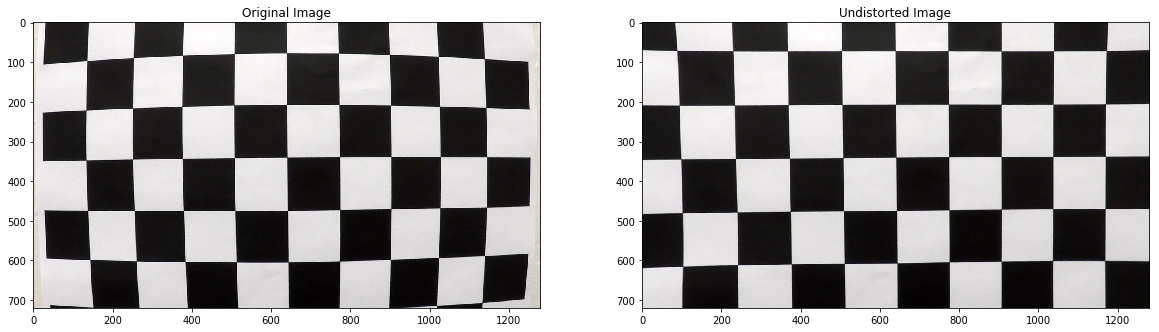

In [5]:

import cv2
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.pyplot.ion()

def calibration_test():
    img = Utils.readInRGB("./camera_cal/calibration1.jpg")
    undist = distortion_corrector.cal_undistort(img)
    Utils.displaySideBySide(img, "Original Image",
        undist, "Undistorted Image")
    
calibration_test()

In [6]:
class PerspectiveTransformer:
    def __init__(self, distortion_corrector):
        self.M = None
        self.Minv = None
        self.distortion_corrector = distortion_corrector
        
    def train(self, img, color_schema=None):
        original = np.copy(img)
        if color_schema is not None:
            original = cv2.cvtColor(img, color_schema)
        undist = self.distortion_corrector.cal_undistort(img)

        
        src = np.float32([[490, 482],[810, 482],
                          [1250, 720],[40, 720]])
        dst = np.float32([[0, 0], [1280, 0], 
                         [1250, 720],[40, 720]])
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        
    def transform(self, img, color_schema=None, verbose=0):
        original = np.copy(img)
        if color_schema is not None:
            original = cv2.cvtColor(img, color_schema)
        undist = self.distortion_corrector.cal_undistort(img)
        warped = self.transformWithoutUndistort(undist)

        if verbose != 0:
            Utils.displaySideBySide(
                original, 'Original',
                warped, 'Perspective transformed')
        return warped
        
    def transformWithoutUndistort(self, img):
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, self.M, img_size)

    def inverseTransformWithoutUndistort(self, img):
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, self.Minv, img_size)
    
testImages = list(map(lambda imageFileName: (imageFileName, Utils.readInRGB(imageFileName)), 
                      glob.glob('./test_images/*.jpg')))            
perspective_transformer = PerspectiveTransformer(distortion_corrector)
perspective_transformer.train(testImages[0][1])


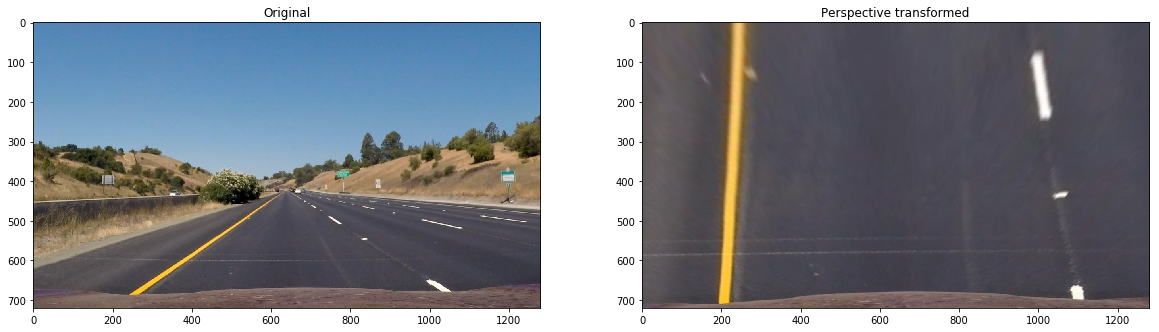

In [7]:
def perspective_transform_test():
    perspective_transformer.transform(testImages[0][1], verbose=1)
    
perspective_transform_test()

./test_images\straight_lines1.jpg
./test_images\straight_lines2.jpg
./test_images\test1.jpg
./test_images\test2.jpg
./test_images\test3.jpg


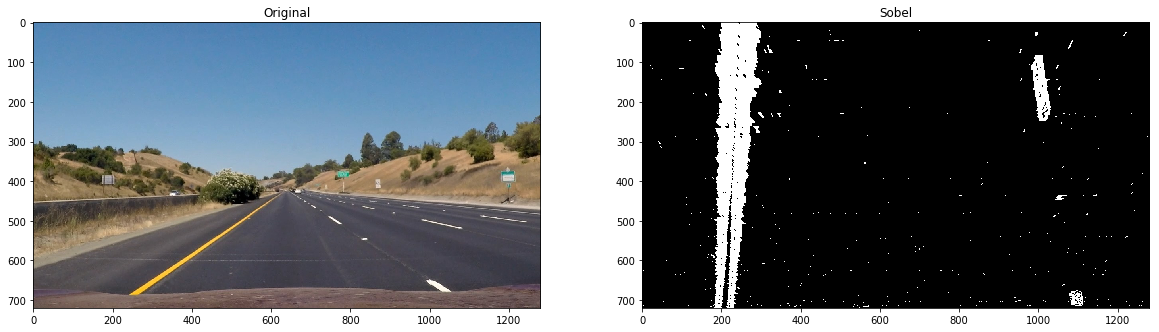

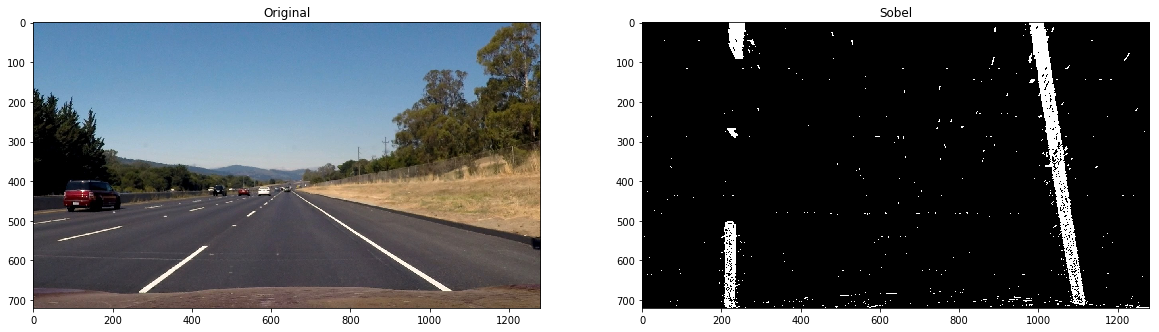

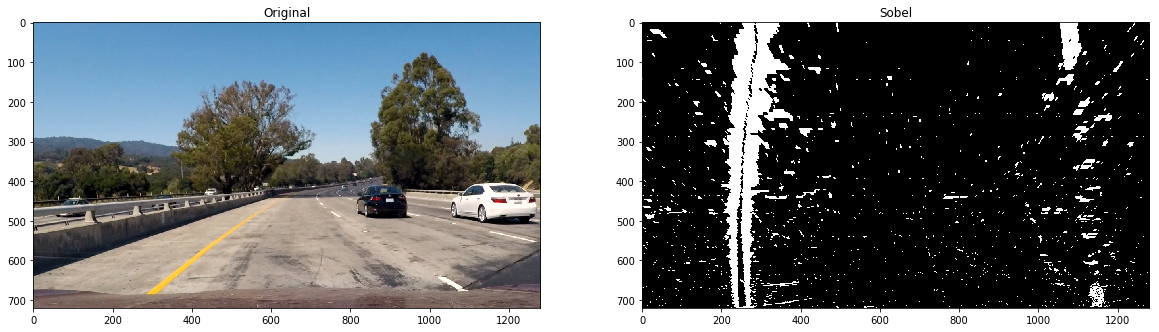

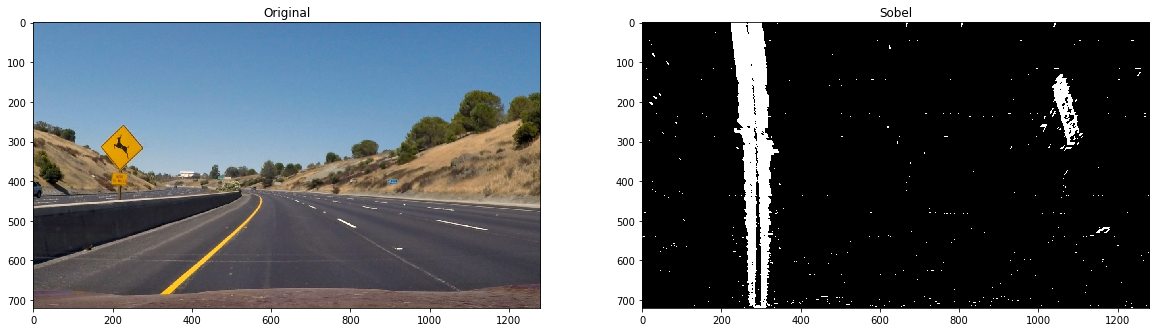

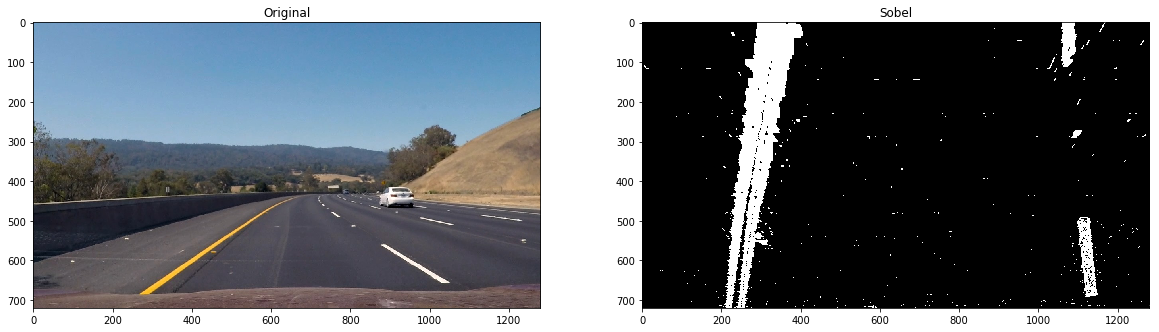

In [8]:
class Sobel:    
    @staticmethod
    # img should be one channel
    def getAbsSobel(img, orient='x', kernel=3):
        yorder = 0
        xorder = 1
        if orient != 'x':
            yorder = 1
            xorder = 0
        sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=kernel)
        abs_sobel = np.absolute(sobel)
        return abs_sobel
    
    @staticmethod
    # img should be one channel
    def getMagSobel(img, orient='x', kernel=3):
        abs_sobel = Sobel.getAbsSobel(img, orient, kernel)
        max_val = np.max(abs_sobel)
        scaled = np.uint(255.0*abs_sobel/max_val)
        return scaled
    
    @staticmethod
    # img should be one channel
    def getSobelDirection(img, kernel=3):
        abs_sobel_x = Sobel.getAbsSobel(img, orient='x', kernel=kernel)
        abs_sobel_y = Sobel.getAbsSobel(img, orient='y', kernel=kernel)
        grad_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
        return grad_dir
    
    @staticmethod
    def getThresholdedSobelDirection(img, kernel=3, thresh=(0.85, 1.15)):
        grad_dir = Sobel.getSobelDirection(img, kernel)
        binary_output =  np.zeros_like(grad_dir)
        binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
        return binary_output
    
    @staticmethod
    # img should be one channel
    def getMagThresholdedSobel(img, orient='x', kernel=3, thresh_min=0, thresh_max=255):
        sobel = Sobel.getMagSobel(img, orient, kernel)
        binary = np.zeros_like(img)
        binary[((thresh_min <= sobel) & (sobel <= thresh_max))] = 1
        return binary
    
    @staticmethod
    # img should be one channel    
    def combineMagSobels(img, kernel = 3, thresh_min_x=0, thresh_max_x=160, thresh_min_y=10, thresh_max_y=160):
        sobel_x = Sobel.getMagThresholdedSobel(img, 'x', kernel, thresh_min_x, thresh_max_x)
        sobel_y = Sobel.getMagThresholdedSobel(img, 'y', kernel, thresh_min_y, thresh_max_y)
        combined = np.zeros_like(sobel_x)
        combined[((sobel_x == 1) & (sobel_y == 1))] = 1
        return combined
    
    @staticmethod
    # img should be RGB  image
    def combineMagSobelsFromRGB(img, kernel = 3, thresh_min_x=0, thresh_max_x=160, thresh_min_y=10, thresh_max_y=160):
        simg = HLSUtils.getSChannel(img, distortion_corrector)
        return Sobel.combineMagSobels(simg)
    
    @staticmethod
    # img should be RGB image
    # return perspective transformed edges
    def combineMagSobelsAndTransform(img, perspective_transformer):
        binary_img = Sobel.combineMagSobelsFromRGB(img)
        transformed_img = perspective_transformer.transformWithoutUndistort(binary_img)
        return transformed_img

    @staticmethod
    # img should be RGB image
    # return perspective transformed edges
    def combineDirSobelsAndTransform(img, perspective_transformer):
        simg = HLSUtils.getSChannel(img, distortion_corrector)
        binary_img = Sobel.getThresholdedSobelDirection(simg)
        transformed_img = perspective_transformer.transformWithoutUndistort(binary_img)
        return transformed_img
    
    @staticmethod
    def combineAllSobelsFromRGBAndTransform(img, pers_transformer):
        undist = distortion_corrector.cal_undistort(img)
        mag_sobels = Sobel.combineMagSobelsAndTransform(undist, pers_transformer)
        dir_sobels = Sobel.combineDirSobelsAndTransform(undist, pers_transformer)
        binary_img = np.zeros_like(mag_sobels)
        binary_img[(mag_sobels == 1) | (dir_sobels == 1)] = 1
        return binary_img
    
def testSobel(index):
    print(testImages[index][0])
    img = testImages[index][1]
    binary_img = Sobel.combineAllSobelsFromRGBAndTransform(img, perspective_transformer)
    Utils.displaySideBySide(
                img, 'Original',
                binary_img, 'Sobel', right_cmap='gray')    
    
    
testSobel(0)
testSobel(1)
testSobel(2)
testSobel(3)
testSobel(4)

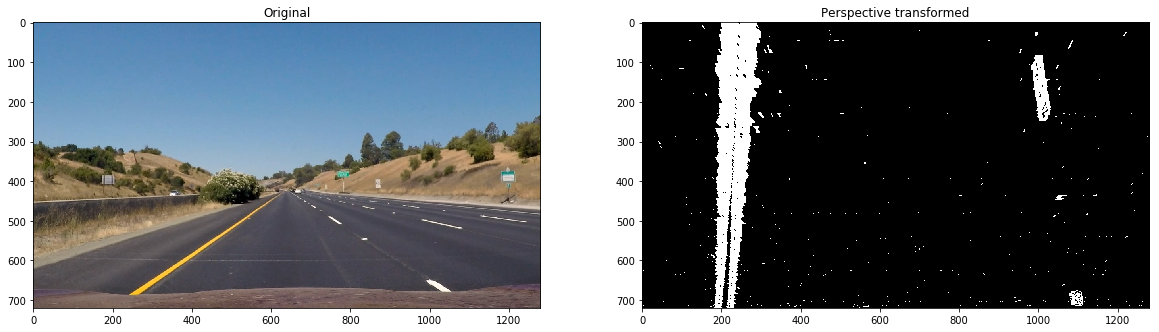

In [9]:
img = testImages[0][1]
transformed_img = Sobel.combineAllSobelsFromRGBAndTransform(img, perspective_transformer)
Utils.displaySideBySide(
                img, 'Original',
                transformed_img, 'Perspective transformed', right_cmap='gray')  

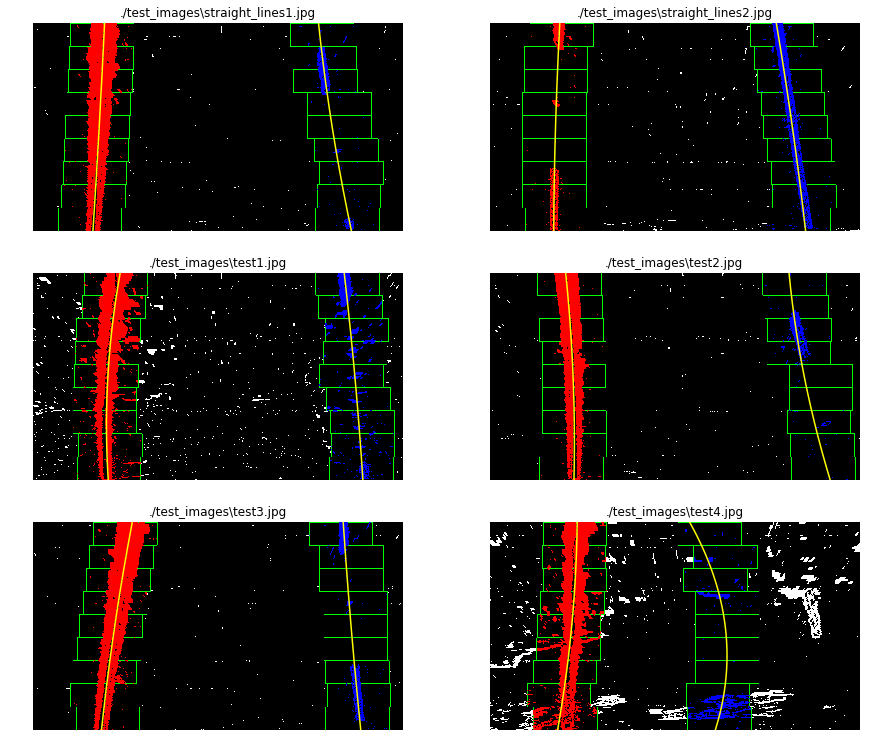

In [10]:
# THIS PART OF CODE IS COMING FROM LECTURE NOTES
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def detectLines(image, left_fit_prev = None, right_fit_prev = None):
    if left_fit_prev is None or right_fit_prev is None:
        return findLines(image)
    else:
        return findLinesFromPrevFit(image, left_fit_prev, right_fit_prev)

def findLines(image, nwindows=9, margin=110, minpix=50, verbose=0):
    # Make a binary and transform image
    binary_warped = Sobel.combineAllSobelsFromRGBAndTransform(image, perspective_transformer)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if verbose != 0:
        plt.plot(histogram)
        plt.xlim(0, 1280)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def findLinesFromPrevFit(image, left_fit_prev, right_fit_prev):
    binary_warped = Sobel.combineAllSobelsFromRGBAndTransform(image, perspective_transformer)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return (left_fit_new, right_fit_new, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def visualizeLanes(image, ax):
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

def showLaneOnImages(images, cols = 2, rows = 3, figsize=(15,13)):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(image, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append( ( imagePathName, left_fit, right_fit, left_fit_m, right_fit_m ) )
    return imageAndFit

imagesPoly = showLaneOnImages(testImages[0:6])

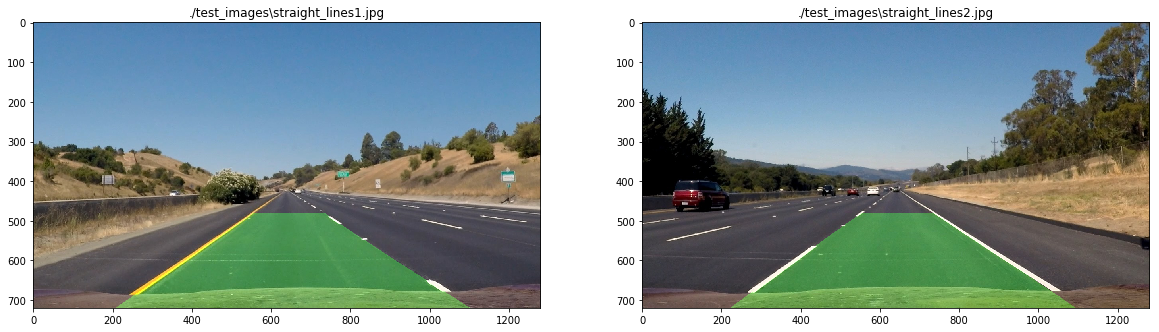

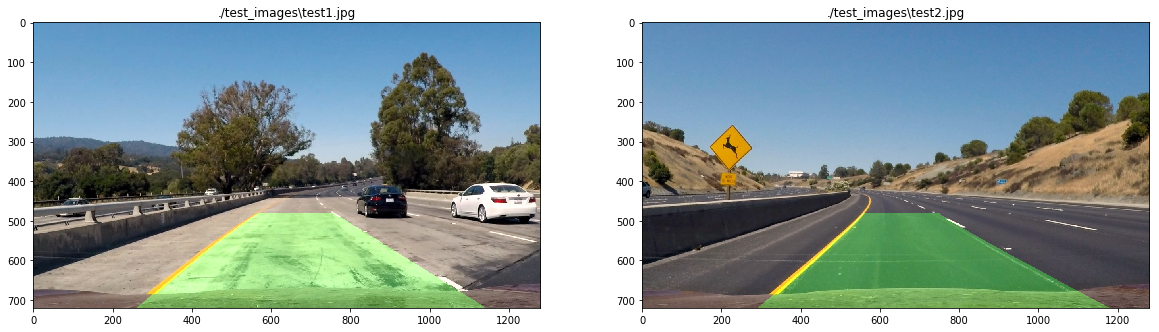

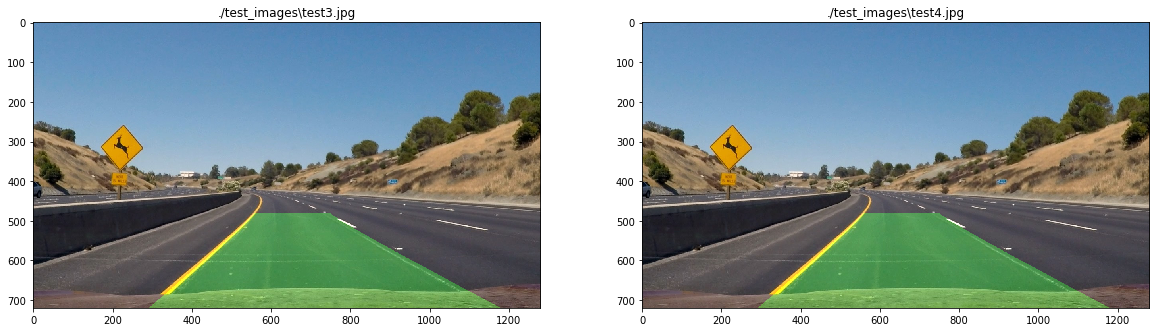

In [11]:

def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    newwarp = perspective_transformer.inverseTransformWithoutUndistort(color_warp) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(img):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = detectLines(img)
    output = drawLine(img, left_fit, right_fit)
    return output

img_with_lanes_1 = drawLaneOnImage(testImages[0][1])
img_with_lanes_2 = drawLaneOnImage(testImages[1][1])
img_with_lanes_3 = drawLaneOnImage(testImages[2][1])
img_with_lanes_4 = drawLaneOnImage(testImages[3][1])
img_with_lanes_5 = drawLaneOnImage(testImages[3][1])
img_with_lanes_6 = drawLaneOnImage(testImages[3][1])
Utils.displaySideBySide(
                img_with_lanes_1, testImages[0][0],
                img_with_lanes_2, testImages[1][0]) 
Utils.displaySideBySide(
                img_with_lanes_3, testImages[2][0],
                img_with_lanes_4, testImages[3][0]) 
Utils.displaySideBySide(
                img_with_lanes_5, testImages[4][0],
                img_with_lanes_6, testImages[5][0]) 

In [12]:
l_line = Line()
r_line = Line()

def updateLines(left_fit, right_fit, left_lane_inds, right_lane_inds):
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(850 - x_int_diff) > 100:
            left_fit = None
            right_fit = None
            
    l_line.addFit(left_fit, left_lane_inds)
    r_line.addFit(right_fit, right_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        return (l_line.best_fit, r_line.best_fit)
    else:
        return (left_fit, right_fit)

def singleImagePipeline(img, left_fit_prev = None, right_fit_prev = None, fontScale=1.5):
    """
    Find and draw the lane lines on the image `img`.
    """
    yRange = img.shape[0]-1
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, _, _, _ = detectLines(img, left_fit_prev, right_fit_prev)
    
    left_fit_new, right_fit_new = updateLines(left_fit, right_fit, left_lane_inds, right_lane_inds)

    if left_fit_new is not None:
        left_fit = left_fit_new
    if right_fit_new is not None:
        right_fit = right_fit_new
        
    output = drawLine(img, left_fit, right_fit)
    
    # Calculate curvature
    leftCurvature = Utils.calculateCurvature(yRange, left_fit_m) 
    rightCurvature = Utils.calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_DUPLEX
    fontColor = (200, 255, 155)
    cv2.putText(output, 'Left Curve Radius: {:.0f} m'.format(leftCurvature), (40, 50), font, fontScale, fontColor, 2, cv2.LINE_AA)
    cv2.putText(output, 'Right Curve Radius: {:.0f} m'.format(rightCurvature), (40, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (40, 190), font, fontScale, fontColor, 2)
    return output

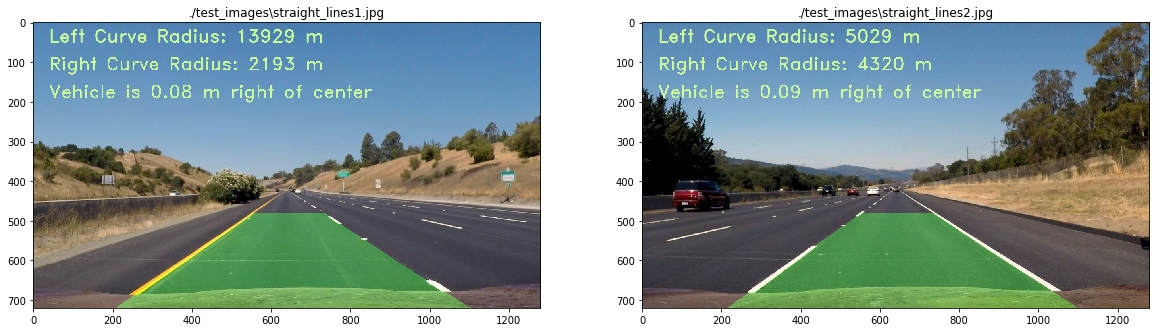

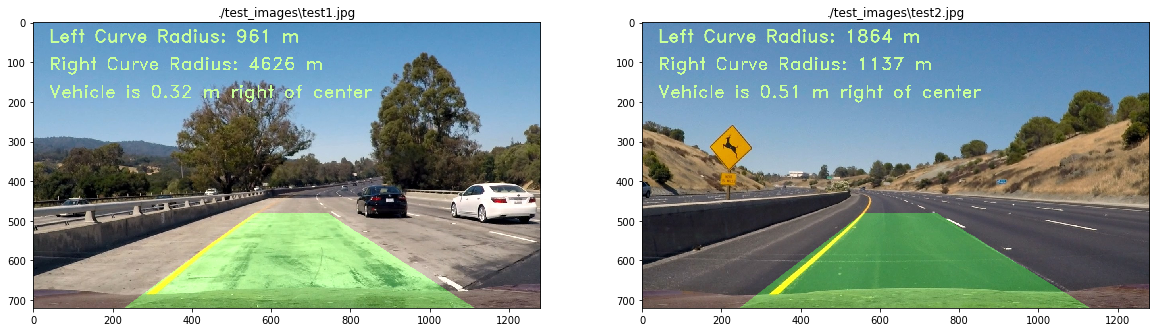

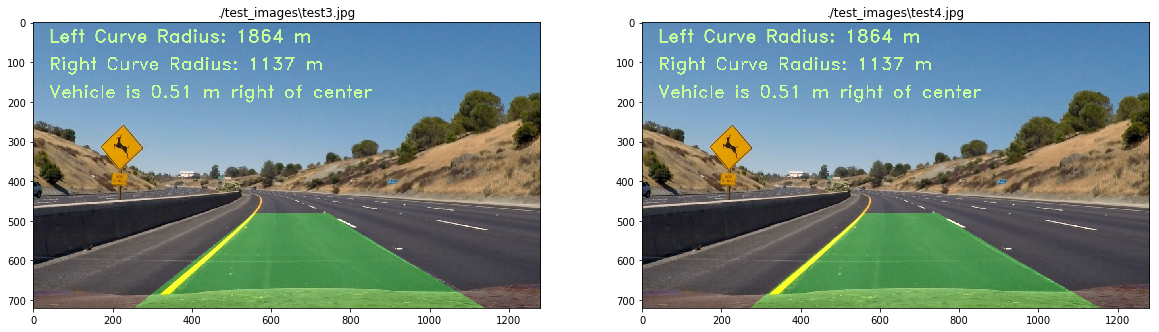

In [13]:
# Visualize lanes with numbers
img_with_lanes_1 = singleImagePipeline(testImages[0][1])
img_with_lanes_2 = singleImagePipeline(testImages[1][1])
img_with_lanes_3 = singleImagePipeline(testImages[2][1])
img_with_lanes_4 = singleImagePipeline(testImages[3][1])
img_with_lanes_5 = singleImagePipeline(testImages[3][1])
img_with_lanes_6 = singleImagePipeline(testImages[3][1])
Utils.displaySideBySide(
                img_with_lanes_1, testImages[0][0],
                img_with_lanes_2, testImages[1][0]) 
Utils.displaySideBySide(
                img_with_lanes_3, testImages[2][0],
                img_with_lanes_4, testImages[3][0]) 
Utils.displaySideBySide(
                img_with_lanes_5, testImages[4][0],
                img_with_lanes_6, testImages[5][0])

In [14]:

def process_image(img):
    result_img = None
    if not l_line.detected or not r_line.detected or l_line.consecutive_cnt > 60:
        l_line.flush()
        r_line.flush()
        result_img = singleImagePipeline(img)
    else:
        result_img = singleImagePipeline(img, l_line.best_fit, r_line.best_fit)
    return result_img
        

In [20]:
from moviepy.editor import VideoFileClip
l_line.flush()
r_line.flush()
consecutive_cnt = 0
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(40,45)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████▉| 1260/1261 [37:56<00:01,  1.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 37min 57s


In [18]:
from moviepy.editor import VideoFileClip
l_line.flush()
r_line.flush()
video_output = 'harder_challenge_video_output.mp4'
# video_input = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,5)
# processed_video = video_input.fl_image(process_image)
# %time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████▉| 1199/1200 [35:08<00:01,  1.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 35min 9s
